### The Culture of International Relations

#### About this project
Cultural treaties are the bi-lateral and multilateral agreements among states that promote and regulate cooperation and exchange in the fields of life generally call cultural or intellectual. Although it was only invented in the early twentieth century, this treaty type came to be the fourth most common bilateral treaty in the period 1900-1980 (Poast et al., 2010). In this project, we seek to use several (mostly European) states’ cultural treaties as a historical source with which to explore the emergence of a global concept of culture in the twentieth century. Specifically, the project will investigate the hypothesis that the culture concept, in contrast to earlier ideas of civilization, played a key role in the consolidation of the post-World War II international order.

The central questions that interest me here can be divided into two groups: 
- First, what is the story of the cultural treaty, as a specific tool of international relations, in the twentieth century? What was the historical curve of cultural treaty-making? For example, in which political or ideological constellations do we find (the most) use of cultural treaties? Among which countries, in which historical periods? What networks of relations were thereby created, reinforced, or challenged? 
- Second, what is the "culture" addressed in these treaties? That is, what do the two signatories seem to mean by "culture" in these documents, and what does that tell us about the role that concept played in the international system? How can quantitative work on this dataset advance research questions about the history of concepts?

In this notebook, we deal with these treaties in three ways:
1) quantitative analysis of "metadata" about all bilateral cultural treaties signed betweeen 1919 and 1972, as found in the World Treaty Index or WTI (Poast et al., 2010).
    For more on how exactly we define a "cultural treaty" here, and on other principles of selection, see... [add this, using text now in "WTI quality assurance"].
2) network analysis of the system of international relationships created by these treaties (using data from WTI, as above).
3) Text analysis of the complete texts of selected treaties. 

After some set-up sections, the discussion of the material begins at "Part 1," below.

In [47]:
%%html
<style>
.jupyter-widgets { font-size: 8pt; }
.widget-label { font-size: 8pt;}
.widget-vbox .widget-label { width: 60px; }
.widget-dropdown > select { font-size: 8pt; }
.widget-select > select { font-size: 8pt; }
.widget-toggle-buttons .widget-toggle-button { font-size: 8pt; width: 100px; }
button[title*='7CORR'] { margin-left: 71px; }
</style>

### <span style='color:blue'>**Mandatory Prepare Step**</span>: Setup Notebook and Load and Process Treaty Master Index
The following code cell to be executed once for each user session. The step loads utility Python code stored in separate files, and imports dependencies to external libraries. The code also loads the WTI master index (and some related data files), and prepares the data for subsequent use.

The treaty data is processed as follows:
- All the treaty data are loaded.Extract year treaty was signed as seperate fields
- Add new fields for specified signed period divisions
- Fields 'group1' and 'group2' are ignored (many missing values). Instead group are fetched via party code from encoding found in the "groups" table.

In [2]:
%load_ext autoreload
%autoreload 2

import os
import warnings
import ipywidgets as widgets
import pandas as pd
import nltk

from nltk.stem import WordNetLemmatizer
from bokeh.plotting import output_notebook
from IPython.display import display, HTML

os.sys.path = os.sys.path if '..' in os.sys.path else os.sys.path + ['..']

warnings.filterwarnings('ignore')

import common.config as config

from common.file_utility import FileUtility
from common.widgets_utility import WidgetUtility
import common.widgets_config as widgets_config
from common.utility import extend, flatten, getLogger
from common.color_utility import StaticColorMap
from common.treaty_state import load_wti_index

import common.network.networkx_utility
from headnode_co_occurrence_gui import display_gui

logger = getLogger(name='cultural_treaties')
wti_index = load_wti_index('../data')

output_notebook()

#import qgrid

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2018-10-12 11:09:48,466 : INFO : Data loaded!


Loading BokehJS ...

### Task: Headnote word toplist and word-pair co-occurence toplist
This report displays headnote toplists either single word occurrance or word-word co-occurrance toplists depending on whether or not the "Co-occurrance" is checked. The result is grouped by selected division's periods or by year.

The word co-occurrance is defined as the number of times a pair of words co-occur in the same headnote. The length of headnotes is ignored in the computation (all pairs have equal weight). Multiple occurance of a word in a headnote is taken into account i.e "cultural exchange cultural" is counted as two co-occurances, and "cultural exchange exchange cultural" is four co-occurrances. Stopwords are removed if "Remove stopwords" are checked.

Stopwords are always removed from the co-occurrance computation, whilst they are removed from single word occurrance toplist if the "Remove stopwords" flag is checked. The removal is based on NLTK's list of english stopwords (run ```nltk.corpus.stopwords.words('english')``` to display all stopwords).

The toplist can be filtered so that only treaties involving any or one of the five parties of interest are included, and words can be excluded based on character length. Each resulting group can also be restricted by both a maximum number of pairs to display per group, as well as a min co-occurrance count.

In [3]:
class HeadnoteTokenCorpus():

    def __init__(self, treaties, tokenize=None, stopwords=None, lemmatize=None, min_size=2):
        
        tokenize = tokenize or nltk.tokenize.word_tokenize
        lemmatize = lemmatize or WordNetLemmatizer().lemmatize
        stopwords = stopwords or nltk.corpus.stopwords.words('english')
        
        self.transforms = [
            tokenize,
            lambda ws: ( x for x in ws if len(x) >= min_size ),
            lambda ws: ( x for x in ws if any(ch.isalpha() for ch in x)),
            lambda ws: list(set(ws)) 
        ]
        
        #if stopwords is not None:
        #    self.transforms += [ lambda ws: ( x for x in ws if x not in stopwords ) ]
            
        #if lemmatizer is not None:
        #    self.transforms += [ lambda ws: ( lemmatizer(x) for x in ws ) ]
        
        treaty_tokens = self._compute_stacked(treaties)
        vocabulary = treaty_tokens.token.unique()
        lemmas = list(map(lemmatize, vocabulary))
        lemma_map = { w: l for (w, l) in zip(*(vocabulary, lemmas)) if w != l }
        stopwords_map = { s : True for s in stopwords }
        treaty_tokens['lemma'] = treaty_tokens.token.apply(lambda x: lemma_map.get(x, x))
        treaty_tokens['is_stopword'] = treaty_tokens.token.apply(lambda x: stopwords_map.get(x, False))

        self.treaty_tokens = treaty_tokens.set_index(['treaty_id', 'sequence_id'])
        
    def _apply_transforms(self, ws):
        '''Splits headnote into tokens and applies specified transforms'''
        for f in self.transforms:
            ws = f(ws)
        return list(ws)
    
    def _parse_headnotes(self, treaties):
        
        headnotes = treaties['headnote']
        
        texts = [ x.lower() for x in list(headnotes) ]
        tokens = list(map(self._apply_transforms, texts))
        df = pd.DataFrame({'headnote': headnotes, 'tokens': tokens })
        
        return df
    
    def _compute_stacked(self, treaties):
        
        df = self._parse_headnotes(treaties)
        
        df_stacked = pd.DataFrame(df.tokens.tolist(), index=df.index).stack()\
            .reset_index().rename(columns={'level_1': 'sequence_id', 0: 'token'})
            
        return df_stacked
    

Preparing headnote corpus for first time use
Index(['sequence_id', 'token', 'lemma', 'is_stopword', 'english', 'french',
       'other', 'party1', 'party2', 'laterality', 'topic', 'ispartyof4',
       'signed_year', 'signed_period', 'signed_period_alt', 'topic_category'],
      dtype='object')


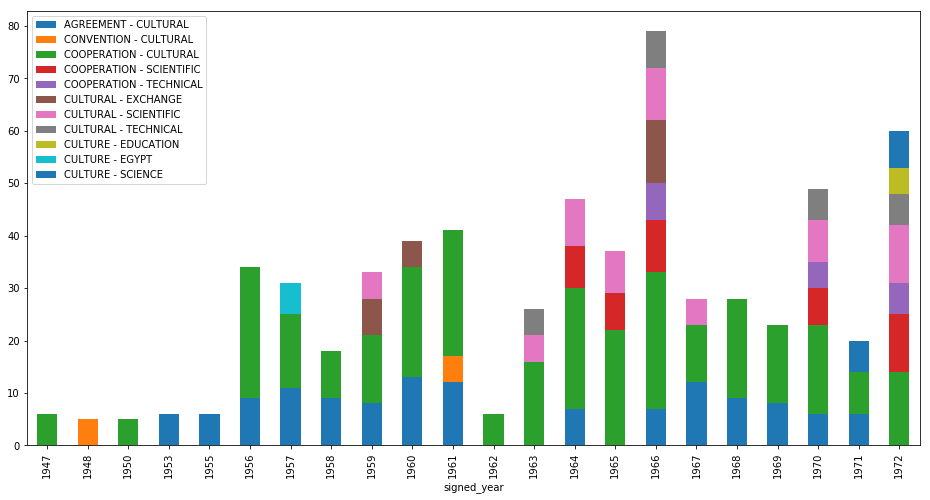

In [5]:
# Code
    
def compute_co_occurrance(treaties):
    
    treaty_tokens = wti_index.treaty_headnote_corpus.treaty_tokens
    i1 = treaties.index
    
    # i2 = treaty_tokens.reset_index().set_index('treaty_id').index
    i2 = treaty_tokens.index.get_level_values(0)
    treaty_tokens = treaty_tokens[i2.isin(i1)]
    
    treaty_tokens = treaty_tokens.loc[treaty_tokens.is_stopword==False]
    treaty_tokens = treaty_tokens.reset_index().drop(['is_stopword', 'sequence_id'], axis=1).set_index('treaty_id')

    co_occurrance = treaty_tokens.merge(treaty_tokens, how='inner', left_index=True, right_index=True)
    co_occurrance = co_occurrance.loc[(co_occurrance['token_x'] < co_occurrance['token_y'])]
    #co_occurrance['token'] = co_occurrance.apply(lambda row: row[groupby_pair[0]] + ' - ' + row[groupby_pair[1]], axis=1)
    co_occurrance['token'] = co_occurrance.apply(lambda row: ' - '.join([row['token_x'].upper(), row['token_y'].upper()]), axis=1)
    co_occurrance['lemma'] = co_occurrance.apply(lambda row: ' - '.join([row['lemma_x'].upper(), row['lemma_y'].upper()]), axis=1)
    co_occurrance = co_occurrance.assign(is_stopword=False, sequence_id=0)[['sequence_id', 'token', 'lemma', 'is_stopword']]
    
    return co_occurrance

def create_bigram_transformer(documents):
    import gensim.models.phrases
    bigram = gensim.models.phrases.Phrases(map(nltk.tokenize.word_tokenize, documents))
    return lambda ws: bigram[ws]

def remove_snake_case(snake_str):
    return ' '.join(x.title() for x in snake_str.split('_'))

def get_top_partiesssss(data, period, party_name, n_top=5):
    xd = data.groupby([period, party_name]).size().rename('TopCount').reset_index()
    top_list = xd.groupby([period]).apply(lambda x: x.nlargest(n_top, 'TopCount'))\
        .reset_index(level=0, drop=True)\
        .set_index([period, party_name])
    return top_list

def display_headnote_toplist(
    period_group_index=None,
    topic_group_name=None,
    recode_is_cultural=False,
    treaty_filter=None,
    parties=None,
    extra_groupbys=None,
    use_lemma=False,
    compute_co_occurance=False,
    remove_stopwords=True,
    min_word_size=2,
    n_min_count=1,
    output_format='table',
    n_top=50,
    progress=None,
    wti_index=None
):
    try:
        
        period_group = config.DEFAULT_PERIOD_GROUPS[period_group_index]
        topic_group = config.TOPIC_GROUP_MAPS[topic_group_name]
    
        progress()

        treaties = wti_index.get_categorized_treaties(
            topic_category=topic_group,
            period_group=period_group,
            treaty_filter=treaty_filter,
            recode_is_cultural=recode_is_cultural
        )
        
        if wti_index.treaty_headnote_corpus is None:
            print('Preparing headnote corpus for first time use')
            wti_index.treaty_headnote_corpus = HeadnoteTokenCorpus(treaties=treaties)
        
        if parties is not None and not 'ALL' in parties:
            ids = wti_index.stacked_treaties.loc[(wti_index.stacked_treaties.party.isin(parties))].index
            treaties = treaties.loc[treaties.index.isin(ids)]

        if treaties.shape[0] == 0:
            print('No data for selection')
            return
        
        progress()

        if compute_co_occurance:

            treaty_tokens = compute_co_occurrance(treaties)

        else:

            treaty_tokens = wti_index.treaty_headnote_corpus.treaty_tokens

            if remove_stopwords is True:
                treaty_tokens = treaty_tokens.loc[treaty_tokens.is_stopword==False]

            treaty_tokens = treaty_tokens.reset_index().set_index('treaty_id')

        progress()

        treaty_tokens = treaty_tokens\
            .merge(treaties, how='inner', left_index=True, right_index=True)\
            .drop(['source', 'signed', 'headnote', 'is_cultural', # 'is_cultural_yesno', 'sequence',
                   'topic1', 'topic2', 'title'], axis=1)

        progress()

        token_or_lemma = 'token' if not use_lemma else 'lemma'
        
        print(treaty_tokens.columns)
        
        groupbys  = []
        groupbys += [ period_group['column'] ] if not period_group is None else []
        groupbys += (extra_groupbys or [])
        groupbys += [ token_or_lemma ]

        result = treaty_tokens.groupby(groupbys).size().reset_index().rename(columns={0: 'Count'})

        progress(5)

        ''' Filter out the n_top most frequent words from each group '''
        result = result.groupby(groupbys[-1]).apply(lambda x: x.nlargest(n_top, 'Count'))\
            .reset_index(level=0, drop=True)\
            # .set_index(groupbys)

        if min_word_size > 0:
            result = result.loc[result[token_or_lemma].str.len() >= min_word_size]

        if n_min_count > 1:
            result = result.loc[result.Count >= n_min_count]

        progress()

        result = result.sort_values(groupbys[:-1] + ['Count'], ascending=len(groupbys[:-1])*[True] + [False])

        progress()

        if output_format in ('table', 'qgrid'):
            result.columns = [ remove_snake_case(x) for x in result.columns ]
            if output_format == 'table':
                display(result)
            else:
                qgrid_widget = qgrid.show_grid(result, show_toolbar=True)
                qgrid_widget
        elif output_format == 'unstack':
            result = result.set_index(groupbys).unstack(level=0).fillna(0).astype('int32')
            result.columns = [ x[1] for x in result.columns ]
            display(HTML(result.to_html()))
        elif output_format.startswith('plot'):
            parts = output_format.split('_')
            kind = parts[-1]
            stacked = 'stacked' in parts
            result = result.set_index(list(reversed(groupbys))).unstack(level=0).fillna(0).astype('int32')
            result.columns = [ x[1] for x in result.columns ]
            result.plot(kind=kind, stacked=stacked, figsize=(16,8))
            
        progress(0)

    except Exception as ex:
        raise
        logger.error(ex)
    finally:        
        progress(0)

display_gui(wti_index, display_headnote_toplist)
